In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
import CRTS_paper_modules as mod
import datetime
from matplotlib import rcParams
from scipy.optimize import curve_fit
from collections import OrderedDict

** What happens here ** 

I apply correction factors per magnitude bin,  and plot the resulting SF in the observed frame, to make Fig. 4 

I use a different fc for each magnitude range, as derived in E_Fig3_histogram  

    mag     | fc 
    17-18   | 0.0890
    18-18.5 | 1.1072
    18.5-19 | 1.2876
    
These numbers are derived from histograms of  the quantity $\chi$ calculated for Blue Stars, they are stored in data_products/Fig_3_data/2017-01-10/r_cut_minMag_maxMag_mean_fc.txt 



In [59]:
# If we were using the full linear fit to the correction factor as a function of timescale...
# We are not, because the timescale-dependence is much smaller than the magnitude-dependence 
# Read in the linear correction coefficients....
file = '../data_products/Fig_3_data/2017-01-10/r_cut_minMag_maxMag_mean_fc.txt'
data = np.loadtxt(file, unpack=True)

Min_arr = np.array(data[0])
Max_arr = np.array(data[1])
fc = data[2]


In [61]:
# Set a directory to save the results...
# the Fig_4_data directory 
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_4_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_4_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')

# the appropriate date subfolder... 
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)

print('Today we will save our Fig_4 files in %s'%outDir)

Today we will save our Fig_4 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-11/


In [65]:
# override the outDir to finish calculations from yesterday ...
outDir = '/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/'

## Read in xi, ei  for the objects in a given mag range ... 

In [66]:
cols1, qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()

Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for 48250 stars from CRTS 


Need to loop reading-in of xi, ei, and calculating SF, over the three magnitude ranges... 

NOTE : the cell below takes ~10 mins to execute on a laptop.... 

In [67]:
# Set the magnitude range 
Min  = 18.5
Max  = 19

objects_in_cut = {}

mag = 'r'
cut_mag = mag

print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))

# use only qso and blue stars since these are the ones that we are plotting ...
good_ids_S_blue = mod.cut_stars(star_cat = star_cat, mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                          gi_Max=1, cut_mag=cut_mag + '_mMed')

good_ids_QSO, redshift = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                           cut_mag=cut_mag, redshift='Yes')
objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'qso':good_ids_QSO}


## Since I'm only using r_cut,   I won't compare it with g_cut .  Thus making r_bin is the same as r_cut  

bins = {}
bin_types = ['r_cut']

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]
    
## Read in the xi, ei for objects in that mag range ... 
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print('Reading in xi, ei for bin %s'% b)
out_dic[b] = {}   # initialize the dic 
#out_dic_rest[b] = {} 

good_ids_S_blue = bins[b]['starsB']
good_ids_QSO = bins[b]['qso']

qso_obs, starB =  mod.read_xi_ei(inDirStars, good_ids_S_blue, inDirQSO, good_ids_QSO)
#qso_rest, starB  =  mod.read_xi_ei(inDirStars, good_ids_S_blue, inDirQSO, good_ids_QSO, redshift=redshift)
# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'qso':qso_obs}

# restframe dictionaries : not needed now... 
#out_dic_rest = {}
#out_dic_rest[b] = {} 
#out_dic_rest[b] = {'starsB': starB, 'qso':qso_rest}

print('finished')



Using now only lightcurves with SDSS  18.500000< r < 19.000000

 These cuts reduced the number of stars  in the sample from 48250 to 1496
Returning only QSO which had an SDSS counterpart within 0.000278 radians

 These cuts reduced the number of qso  in the sample from 7601 to 747
Also returning quasar redshifts...
Reading in xi, ei for bin r_cut
making new delflx, tau, xi arrays


Reading in quasars...
Returning delta_time in observed frame, t_obs
[######### ] 99.73%

Reading in blue stars ...
[######### ] 99.93%



## Calculate sigma approx and sigma full, applying correction factor to errors in each bin 

In [68]:
# for all imports of my functions, 
# make python aware of my packages...
import sys
sys.path.insert(0, '../../SDSS_S82_FP_research/S82analysis/packages/')
import variabilityFunctions as varF


In [69]:
# set the bin number 
nbins = 200 

# grab the right correction factor for the given magnitude range... 
fc_mag = fc[Min_arr == Min][0]
          
print('Today we will save our Fig_4 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in ['qso','starsB'] : # out_dic[b].keys()
    print('\n For obj = %s'% obj)
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic['r_cut'][obj][0]
    tau =  out_dic['r_cut'][obj][1]
    e_ij = fc_mag * out_dic['r_cut'][obj][2]  # apply the correction factor 


    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    
    # Make an array of correction coefficients per bin, using the coefficients from the file ...  
    #a = coeffs['a'][coeffs['rMagMin'] == Min]
    #b = coeffs['b'][coeffs['rMagMin'] == Min]
    #binned_fc =  a* np.log10(binned_tau[0]) + b
    
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    
    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 
    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]


    # Which point belongs to which bin
    bin_number  = binned_tau[2]

    ####  Panel 1 : Standard Deviation 
    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned[0][non_empty_bins]  


    ##### Panel 2  : Gaussian rms  
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    # Loop over all bins  calculating approximate mu and sigma 
    mu_bins = {}
    sig_bins = {}

    sig_bins['approx'] = np.zeros(nbins)
    mu_bins['approx'] = np.zeros(nbins)
    sig_bins['full'] = np.zeros(nbins)
    mu_bins['full'] = np.zeros(nbins)
    
    for N in np.unique(bin_number):
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        ei = e_ij[bin_number == N]
    
        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        sig_bins['approx'][N-1] = sig_approx
        sig_bins['full'][N-1] = sig_full
        
        mu_bins['approx'][N-1] = mu_approx
        mu_bins['full'][N-1] = mu_full 

    # Save the results of calculation  : Panel 1,2,3,4 
    fname = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    

    save_data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount '
    np.savetxt(fname, save_data, fmt = '%s', delimiter = ' ' , header=header )
    print('Results saved as %s ' % fname)

print('Done with calculating panel data ')    

Today we will save our Fig_4 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/

 For obj = qso
 --- Calculating mu, sigma for bin 1
sigma at the last grid point
 --- Calculating mu, sigma for bin 2
mu at the last grid point
 --- Calculating mu, sigma for bin 3
sigma at the last grid point
 --- Calculating mu, sigma for bin 4
sigma at the last grid point
 --- Calculating mu, sigma for bin 5
mu at the last grid point
sigma at the last grid point
 --- Calculating mu, sigma for bin 6
sigma at the last grid point
 --- Calculating mu, sigma for bin 7
sigma at the last grid point
 --- Calculating mu, sigma for bin 8
sigma at the last grid point
 --- Calculating mu, sigma for bin 9
sigma at the last grid point
 --- Calculating mu, sigma for bin 10
sigma at the last grid point
 --- Calculating mu, sigma for bin 11
sigma at the last grid point
 --- Calculating mu, sigma for bin 12
sigma at the last grid point
 --- Calculating mu, sigma for bin 13
sigma at the l

## Read in plotting data from  saveFiles

If you have  already calculated statistics for each bin,  can simply read the file, and proceed to plotting, skipping steps above. I assume three magnitude bins (17-18, 18-18.5,  18.5-19)  , for two types of objects (blue stars, quasars). 


In [73]:
import numpy as np
#from scipy.optimize import curve_fit
from collections import OrderedDict

# the directory with results previously calculated ... 
outDir = '/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/'

plot_data = OrderedDict()

Min_arr = [17,18,18.5]
Max_arr = [18, 18.5, 19]

for mag in Min_arr:
    plot_data[mag] = OrderedDict()
    
for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]
    for obj in ['qso','starsB']:
        plot_data[Min][obj] = {}
        
        fname =  outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
        print('Loading... %s'% fname) 
        
        colnames = open(fname,'r').read().splitlines()[0][1:].split()
        d = np.genfromtxt(fname, dtype=float)
        
        for label, column in zip(colnames, d.T):
            plot_data[Min][obj][label] = column
        



Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/r_cut_17-18_qso.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/r_cut_17-18_starsB.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/r_cut_18-18.5_qso.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/r_cut_18-18.5_starsB.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/r_cut_18.5-19_qso.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_4_data/2017-01-10/r_cut_18.5-19_starsB.txt


## Plot the data 

Most recent calculation, using a magnitude-specific correction factor : 2017-01-10

/Users/chris/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


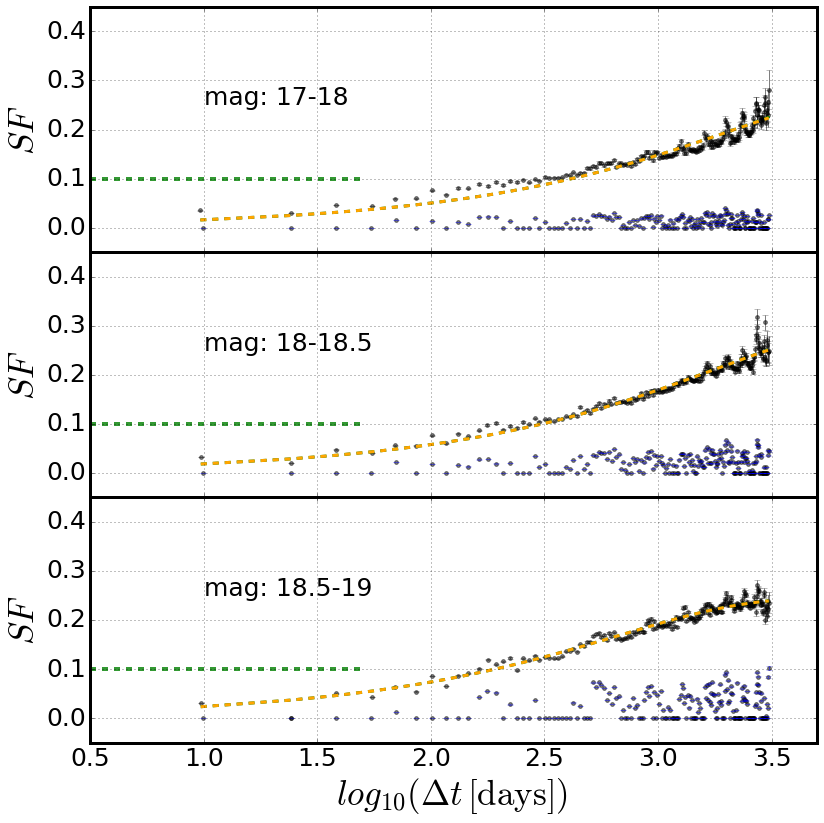

In [79]:


%matplotlib inline

def model_sf(t, sf_inf=0.25, tau = 1.0):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf
        
        
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25
rcParams.update({'figure.autolayout': False})


obj_arr = ['qso',  'starsB']
labels_arr = ['Quasars', 'Blue Stars']
colors = ['black','blue']

# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 #7
p_al   = 0.5 

# y limits for SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7

b = 'r_cut'

fig,ax = plt.subplots(3,1, figsize=(12,12), sharex=True)

for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]
    for j in range(len(obj_arr)):
        obj = obj_arr[j]
        
        plot = plot_data[Min][obj]
        
        #ax[i].scatter(np.log10(plot['meanTau']), plot['sigmaApprox'],  s=p_size, 
        #            alpha=p_al, label=labels_arr[j], 
        #              color=colors[j])
        #err_sig = plot['sigmaApprox']* 1.06 / np.sqrt(plot['binCount'])
        
        #ax[i].errorbar(np.log10(plot['meanTau']), plot['sigmaApprox'],err_sig, linestyle='None',
        #               color=colors[j],   alpha=p_al)#
        
        ax[i].scatter(np.log10(plot['meanTau']), plot['sigmaFull'], s=p_size, 
                    alpha=p_al, c =colors[obj_arr==obj])
        err_sig = plot['sigmaFull']* 1.06 / np.sqrt(plot['binCount'])
        
        ax[i].errorbar(np.log10(plot['meanTau']), plot['sigmaFull'],err_sig, linestyle='None',
                       color=colors[j],   alpha=p_al)#
        
        if obj == 'qso' : 
            # Calculate the model DRW fit for QSO
        
            xdata = plot['meanTau']
            sf = plot['sigmaFull']
            popt, pcov = curve_fit(model_sf, xdata, sf)
            y = model_sf(xdata, sf_inf=popt[0], tau = popt[1]) # tau 1 year in days 

            # Fold-in the error to the model SF , plot 
            # both folded and not-folded version 
            y_fold = np.sqrt((y ** 2.0)+ (err_sig ** 2.0) )
            ax[i].plot(np.log10(xdata), y_fold , lw=3, c = 'green', ls='--')
            ax[i].plot(np.log10(xdata), y , lw=3, c = 'orange', ls='--')

            # text = r'$ \mathrm{Model:}\ \tau=%.3f \,\mathrm{days} , \ SF_{\infty}=%.3f \,\mathrm{mag}$'%(popt[1],popt[0])
            # ax[i].text(x=0.75, y=0.3,s = text )

            
for i in range(len(Min_arr)) :
    
    ax[i].text(1.0, 0.25, 'mag: '+str(Min_arr[i])+'-'+str(Max_arr[i]) )
  
    ax[i].set_ylabel(r'$SF$')
    ax[i].set_ylim(bottom=y_bott, top=y_top)
    ax[i].set_xlim(left=x_left, right=x_right)
    ax[i].grid() 
    ax[i].hlines(y=0.1, xmin =0.5, xmax=1.7, color='green', lw = 4, linestyle = '--' , alpha = 0.8  )

    ax[i].set_yticks([0,0.1,0.2,0.3,0.4])
    ax[i].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
    
axbox = ax[0].get_position()
x_value=0.3
y_value=0.15
legend = ax[0].legend(fancybox=True,loc=(axbox.x0 + x_value, axbox.y0 - y_value), fontsize=25)
#rcParams['legend.numpoints'] = 1
#legend.get_frame().set_edgecolor('1.0')
#legend.get_frame().set_alpha(0.5)
#plt.rc('legend',**{'fontsize':16})
#plt.setp(plt.gca().get_legend().get_texts(), fontsize='12')

ax[-1].set_xlabel(r'$log_{10} (\Delta {t} \, \mathrm{[days]})$ ') 
#legend = ax[0].legend(fancybox=True,loc=(axbox.x0 + x_value, axbox.y0 - y_value), fontsize=25)
#ax[-1].set_xlabel(r'$\log_{10}{\tau}$', fontsize=20)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig(outDir+'Fig_4_SF_QSO_starsB_r_cut.png')
plt.show()

## Look at the last few bins in qso both in observed frame, and after the redshift-correction. 



In [151]:
out_dic['r_cut']['qso']

(array([ 0.2743, -0.1458,  0.1804, ..., -0.2225, -0.2875, -0.1983]),
 array([  9.02300000e-01,   9.59600000e-01,   9.75600000e-01, ...,
          2.88712210e+03,   2.91016730e+03,   2.97669700e+03]),
 array([ 0.11183761,  0.12984976,  0.08991691, ...,  0.06020797,
         0.06020797,  0.18515172]),
 array(['235008.88-002912.5', '235008.88-002912.5', '235008.88-002912.5',
        ..., '002146.71-004847.9', '002146.71-004847.9',
        '002146.71-004847.9'], 
       dtype='|S18'))

In [156]:
nbins = 200 

obj = 'qso'

m_ij = out_dic['r_cut'][obj][0]
tau =  out_dic['r_cut'][obj][1]
tauR = out_dic_rest['r_cut'][obj][1]
e_ij = out_dic['r_cut'][obj][2]
n_ij  = out_dic['r_cut'][obj][3]

In [157]:
len(np.unique(n_ij))

747

In [158]:
# Grab redshifts... one for each qso
msk = np.in1d(qso_cat['CRTS_id'],  np.unique(n_ij) )
names = qso_cat['CRTS_id'][msk]
zs = qso_cat['redshift'][msk]
zs = np.array(zs).astype(float)

In [159]:
# Express redshifts as one per delta_mag 

zs_cnt = np.zeros_like(e_ij, dtype=float)
for i in range(len(e_ij)): 
    zs_cnt[i] = zs[names == n_ij[i]][0]

In [180]:
# Redshift-corrected by hand- are they the same as in read_xi_ei ? 
np.sum(tau / (1.0+zs_cnt) ==  tauR) == len(tau)
# Yes ! 

True

In [219]:
tauC = tau / (1.0+zs_cnt)

In [216]:
outDir

'/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/'

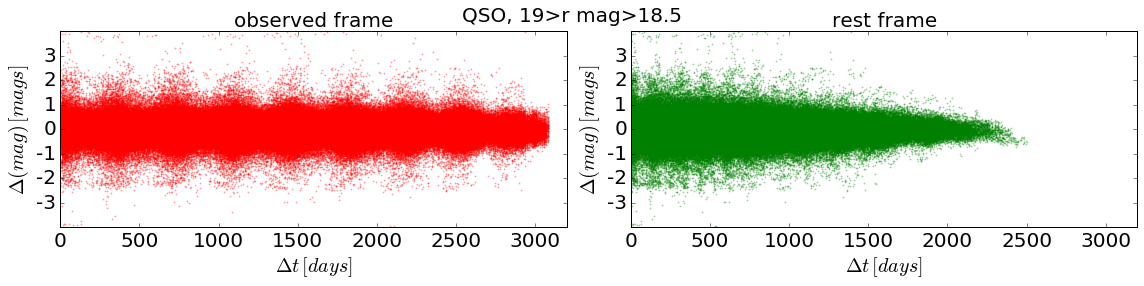

In [220]:
fig,ax = plt.subplots(1,2, figsize=(16,4))
N=100000
ax[0].scatter(tau[N:], m_ij[N:], s=3, lw=0, alpha=0.4, color='red')
ax[1].scatter(tauC[N:], m_ij[N:], s=3, lw=0, alpha=0.4, color='green')
ax[0].set_ylim(-4,4)
ax[1].set_ylim(-4,4)
ax[0].set_xlim(0,3200)
ax[1].set_xlim(0,3200)
ax[0].set_ylabel(r'$\Delta(mag) \, [mags]$', fontsize=20)
ax[1].set_ylabel(r'$\Delta(mag) \, [mags]$', fontsize=20)
ax[0].set_xlabel(r'$\Delta t \, [days]$', fontsize=20)
ax[1].set_xlabel(r'$\Delta t \, [days]$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_title('observed frame', fontsize=20)
ax[1].set_title('rest frame', fontsize=20)
fig.suptitle('QSO, 19>r mag>18.5', fontsize=20)
ax[0].set_yticks([-3,-2,-1,0,1,2,3])
ax[0].set_yticklabels(['-3','-2','-1', '0', '1','2','3'])
ax[1].set_yticks([-3,-2,-1,0,1,2,3])
ax[1].set_yticklabels(['-3','-2','-1', '0', '1','2','3'])
plt.tight_layout()
fname = outDir + '18.5-19_qso_restframe_obs_frame_tauC_m_ij_linear.png'
plt.savefig(fname)

In [145]:
ax[0].se

    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    
    # Make an array of correction coefficients per bin, using the coefficients from the file ...  
    a = coeffs['a'][coeffs['rMagMin'] == Min]
    b = coeffs['b'][coeffs['rMagMin'] == Min]
    binned_fc =  a* np.log10(binned_tau[0]) + b
    
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    
    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 
    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]


    # Which point belongs to which bin
    bin_number  = binned_tau[2]

    ####  Panel 1 : Standard Deviation 
    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned[0][non_empty_bins]  


    ##### Panel 2  : Gaussian rms  
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    # Loop over all bins  calculating approximate mu and sigma 
    #mu_bins = {}
    #sig_bins = {}

    #sig_bins['approx'] = np.zeros(nbins)
    #mu_bins['approx'] = np.zeros(nbins)
    #sig_bins['full'] = np.zeros(nbins)
    #mu_bins['full'] = np.zeros(nbins)
    
    #for N in np.unique(bin_number)[65:]
        #print('\r --- Calculating mu, sigma for bin %d' % N),
        #xi = m_ij[bin_number == N]
        #fc_bin = binned_fc[N-1]
        #ei = fc_bin * e_ij[bin_number == N]
    
        #mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        #mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        #sig_bins['approx'][N-1] = sig_approx
        #sig_bins['full'][N-1] = sig_full
        
        #mu_bins['approx'][N-1] = mu_approx
        #mu_bins['full'][N-1] = mu_full 

    # Save the results of calculation  : Panel 1,2,3,4 
    #fname = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'rest.txt'
    

    #data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
    #                        sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count, binned_fc))

    #header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount  binFcorr'
    #np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print 'Results saved as ', fname

print 'Done with calculating panel data '    

Today we will save our Fig_4 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/

 For obj =  qso
Results saved as  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18.5-19_starsB_rest.txt
Done with calculating panel data 


In [146]:
# Grab points only for the final 50 bins restframe...

xi_check= np.zeros(0)
ti_check = np.zeros(0)

for N in np.unique(bin_number)[150:]:
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        ti = tau[bin_number == N ]
        xi_check = np.append(xi, xi_check)
        ti_check = np.append(ti, ti_check)
  

 --- Calculating mu, sigma for bin 200


In [121]:
# RESTFRAME 

# set the bin number 
nbins = 200 

          
print('Today we will save our Fig_4 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in ['qso'] : # out_dic[b].keys()
    print '\n For obj = ', obj
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic_rest['r_cut'][obj][0]
    tau =  out_dic_rest['r_cut'][obj][1]
    e_ij = out_dic_rest['r_cut'][obj][2]


    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    
    # Make an array of correction coefficients per bin, using the coefficients from the file ...  
    a = coeffs['a'][coeffs['rMagMin'] == Min]
    b = coeffs['b'][coeffs['rMagMin'] == Min]
    binned_fc =  a* np.log10(binned_tau[0]) + b
    
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    
    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 
    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]


    # Which point belongs to which bin
    bin_number  = binned_tau[2]

    ####  Panel 1 : Standard Deviation 
    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned[0][non_empty_bins]  


    ##### Panel 2  : Gaussian rms  
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    # Loop over all bins  calculating approximate mu and sigma 
    #mu_bins = {}
    #sig_bins = {}

    #sig_bins['approx'] = np.zeros(nbins)
    #mu_bins['approx'] = np.zeros(nbins)
    #sig_bins['full'] = np.zeros(nbins)
    #mu_bins['full'] = np.zeros(nbins)
    
    #for N in np.unique(bin_number)[65:]
        #print('\r --- Calculating mu, sigma for bin %d' % N),
        #xi = m_ij[bin_number == N]
        #fc_bin = binned_fc[N-1]
        #ei = fc_bin * e_ij[bin_number == N]
    
        #mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        #mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        #sig_bins['approx'][N-1] = sig_approx
        #sig_bins['full'][N-1] = sig_full
        
        #mu_bins['approx'][N-1] = mu_approx
        #mu_bins['full'][N-1] = mu_full 

    # Save the results of calculation  : Panel 1,2,3,4 
    #fname = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'rest.txt'
    

    #data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
    #                        sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count, binned_fc))

    #header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount  binFcorr'
    #np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print 'Results saved as ', fname

print 'Done with calculating panel data '    

Today we will save our Fig_4 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/

 For obj =  qso
Results saved as  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18.5-19_starsB_rest.txt
Done with calculating panel data 


In [144]:
# Grab points only for the final 50 bins restframe...

xi_check_rest = np.zeros(0)
ti_check_rest = np.zeros(0)

for N in np.unique(bin_number)[150:]:
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        ti = tau[bin_number == N ]
        xi_check_rest = np.append(xi, xi_check_rest)
        ti_check_rest = np.append(ti, ti_check_rest)
  

 --- Calculating mu, sigma for bin 200


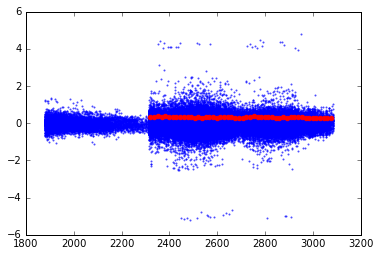

In [148]:
plt.scatter(ti_check_rest, xi_check_rest, s =4, lw=0, alpha=0.7)
plt.scatter(ti_check, xi_check, s =4, lw=0, alpha=0.7)
plt.scatter(mean_tau[150:], bin_stdev[150:], color='red')

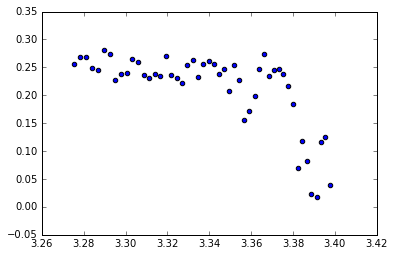

In [128]:
plt.scatter(np.log10(mean_tau[150:]), bin_sigma_G[150:])

### Look at the last few bins for qso : first in the observed frame, and check the distribution of redshifts for points in that sample ..

In [8]:
# set the bin number 
nbins = 200 

          
print('Today we will save our Fig_4 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in ['qso'] : # out_dic[b].keys()
    print '\n For obj = ', obj
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic['r_cut'][obj][0]
    tau =  out_dic['r_cut'][obj][1]
    e_ij = out_dic['r_cut'][obj][2]
    names  = out_dic['r_cut'][obj][3]

    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    
    # Make an array of correction coefficients per bin, using the coefficients from the file ...  
    a = coeffs['a'][coeffs['rMagMin'] == Min]
    b = coeffs['b'][coeffs['rMagMin'] == Min]
    binned_fc =  a* np.log10(binned_tau[0]) + b
    
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    
    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 
    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]


    # Which point belongs to which bin
    bin_number  = binned_tau[2]

    ####  Panel 1 : Standard Deviation 
    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned[0][non_empty_bins]  


    ##### Panel 2  : Gaussian rms  
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    # Loop over all bins  calculating approximate mu and sigma 
    mu_bins = {}
    sig_bins = {}

    sig_bins['approx'] = np.zeros(nbins)
    mu_bins['approx'] = np.zeros(nbins)
    sig_bins['full'] = np.zeros(nbins)
    mu_bins['full'] = np.zeros(nbins)
    
    ni_gt_3 = [] 
    
    for N in np.unique(bin_number)[65:]:  # bin 65 is log(tau) > 3.0 
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        fc_bin = binned_fc[N-1]
        ei = fc_bin * e_ij[bin_number == N]
        ni = names[bin_number == N]
        
        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        sig_bins['approx'][N-1] = sig_approx
        sig_bins['full'][N-1] = sig_full
        
        mu_bins['approx'][N-1] = mu_approx
        mu_bins['full'][N-1] = mu_full 

        ni_gt_3.append(ni)
    # Save the results of calculation  : Panel 1,2,3,4 
    fname = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    

    data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count, binned_fc))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount  binFcorr'
    #np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print 'Results saved as ', fname

print 'Done with calculating panel data '    

Today we will save our Fig_4 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-22/

 For obj =  qso
 --- Calculating mu, sigma for bin 200 Results saved as  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-22/r_cut_18.5-19_qso.txt
Done with calculating panel data 


In [55]:
# I figure out which bin has log(tau) > 3 ... 
# np.arange(200)[np.log10(mean_tau)>3]

In [9]:
ni_check = np.zeros(0)
for a in ni_gt_3 : 
    ni_check = np.append(a, ni_check)

In [39]:
len(ni_check)

1151631

In [12]:
len(np.unique(ni_check))

747

In [13]:
# pull first only redshifts for those 747 qso in my high-observed-tau sample :
msk = np.in1d(qso_cat['CRTS_id'],  np.unique(ni_check) )
names = qso_cat['CRTS_id'][msk]
zs = qso_cat['redshift'][msk]
zs = np.array(zs).astype(float)

In [14]:
zs_cnt = np.zeros_like(ni_check, dtype=float)
for i in range(len(ni_check)): 
    zs_cnt[i] = zs[names == ni_check[i]][0]

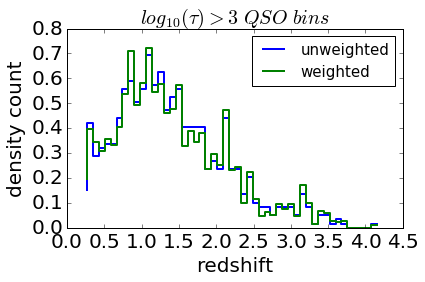

In [53]:
# redshift distribution of quasars that contributed to
# log(tau)>  3 sample 

%matplotlib inline
nbins=50
fig,ax  = plt.subplots(1,1)

# Not weighted by the number of points from a given quasar 
hist1, bin_edges = np.histogram(zs, bins=nbins, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_centres, hist1, ls='steps', label='unweighted', lw=2)

# and also weighted by the number of points from a given quasar...
hist2, bin_edges = np.histogram(zs_cnt, bins=nbins, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_centres, hist2, ls='steps', label='weighted', lw=2)
ax.legend(fontsize=15)
ax.set_xlabel('redshift', fontsize=20)
ax.set_ylabel('density count', fontsize=20)
ax.set_title(r'$log_{10}(\tau) > 3 \,\, QSO \,\, bins$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
name = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_bins_65-200_redshift_distr.png'
plt.savefig(name)
plt.show()


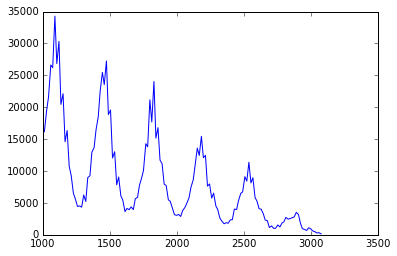

In [50]:
plt.plot(mean_tau[65:], bin_count[65:])


In [106]:
len(tau)

2381082

In [29]:
# Check how does the redshift correction affect the distribution of delta_tau points... 
# bin_number tells each tau, m_ij, e_ij,  point which bin it belongs to ... 
# Pull only those in bins 65 onwards, i.e. log10(tau) > 3.0 
tau_check = np.zeros(0,dtype=float)
for N in np.unique(bin_number)[65:]:
    t_ij = tau[bin_number == N]
    tau_check = np.append(t_ij, tau_check)

In [30]:
tau_restframe = tau_check  / (1.0 + zs_cnt)


/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18.5-19_qso_bins_65-200_delta_t_distr.png


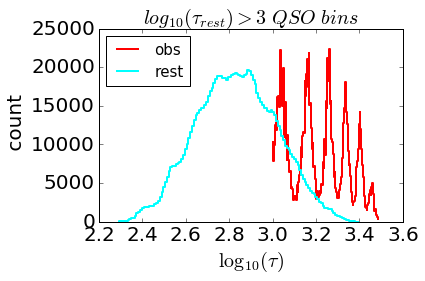

In [103]:
# Compare delta_tau distribution before and after redshift correction 

%matplotlib inline
nbins=135
fig,ax  = plt.subplots(1,1)

# observed frame, no redshift correction... 
hist1, bin_edges = np.histogram(np.log10(tau_check), bins=nbins, density=False)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_centres1, hist1, color='red', ls='steps', label='obs', lw=2)

# and also weighted by the number of points from a given quasar...
hist2, bin_edges = np.histogram(np.log10(tau_restframe), bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_centres2, hist2, color='cyan', ls='steps', label='rest', lw=2)
ax.legend(loc='best', fontsize=15)
ax.set_xlabel(r'$\log_{10}(\tau)$', fontsize=20)
ax.set_ylabel(' count', fontsize=20)
ax.set_title(r'$log_{10}(\tau_{rest}) > 3 \,\, QSO \,\, bins$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
name = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_qso_bins_65-200_delta_t_distr.png'
print(name)
plt.savefig(name)
plt.show()

# so what happens is that I loose a huge amount of points in high-tau bins
# and those few leftover points may happen to have a smaller scatter simply because 
# there is less of them .... (?)
# --> ASK ZELJKO ! 

In [71]:
len(tau_check)

1151631

In [73]:
import numpy as np
#from scipy.optimize import curve_fit
from collections import OrderedDict

# the directory with results previously calculated ... 
outDir = '/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/'

plot_data = OrderedDict()

Min_arr = [17,18,18.5]
Max_arr = [18, 18.5, 19]

for mag in Min_arr:
    plot_data[mag] = OrderedDict()
    
for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]
    for obj in ['qso','starsB']:
        plot_data[Min][obj] = {}
        
        fname =  outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_rest.txt'
        print 'Loading... ', fname 
        
        colnames = open(fname,'r').read().splitlines()[0][1:].split()
        d = np.genfromtxt(fname, dtype=float)
        
        for label, column in zip(colnames, d.T):
            plot_data[Min][obj][label] = column
        

Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_17-18_qso_rest.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_17-18_starsB_rest.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18-18.5_qso_rest.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18-18.5_starsB_rest.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18.5-19_qso_rest.txt
Loading...  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18.5-19_starsB_rest.txt


In [78]:
plot_data[18.5]['qso'].keys()

['sigmaApprox',
 'muFull',
 'muApprox',
 'binCount',
 'sigmaG',
 'sigmaFull',
 'binFcorr',
 'stdev',
 'meanTau']

In [100]:
np.sum(mask)

120

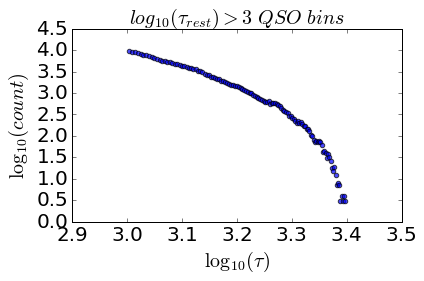

In [101]:
%matplotlib inline
fig,ax  = plt.subplots(1,1)
mask = np.log10(plot_data[18.5]['qso']['meanTau']) > 3
ax.scatter(np.log10(plot_data[18.5]['qso']['meanTau'][mask]),np.log10(plot_data[18.5]['qso']['binCount'][mask]), alpha=0.7)
ax.set_xlabel(r'$\log_{10}(\tau)$', fontsize=20)
ax.set_ylabel(r'$\log_{10}(count)$', fontsize=20)
ax.set_title(r'$log_{10}(\tau_{rest}) > 3 \,\, QSO \,\, bins$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
name = '/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_5_data/2016-06-15/r_cut_18.5-19_qso_delta_t_distr.png'
plt.savefig(name)

In [63]:
plt.plot(mean_tau[65+100:]

array([ 2552.13325571,  2566.5947017 ,  2583.00406334,  2597.79069437,
        2613.103077  ,  2628.03865051,  2644.09264881,  2658.69178317,
        2674.31607065,  2689.64132702,  2706.40071133,  2721.79983473,
        2736.28438102,  2752.47209451,  2768.84791084,  2783.11382517,
        2798.11647214,  2813.19098566,  2829.78593988,  2843.96206955,
        2860.20898872,  2874.49339498,  2891.11025152,  2907.35306685,
        2921.67127355,  2935.9277044 ,  2952.45837738,  2968.98910974,
        2982.92838621,  2999.35433804,  3011.99770828,  3030.72968249,
        3044.77355927,  3059.42643104,  3076.17741074])

In [69]:
np.power(10,bin_centres2)

array([  195.18355068,   198.92261456,   202.7333064 ,   206.61699835,
         210.57508885,   214.60900312,   218.72019369,   222.91014091,
         227.18035352,   231.5323691 ,   235.96775475,   240.48810755,
         245.09505519,   249.79025654,   254.57540223,   259.45221531,
         264.42245181,   269.48790142,   274.65038809,   279.91177075,
         285.27394389,   290.73883833,   296.30842186,   301.98469999,
         307.76971662,   313.66555481,   319.67433754,   325.79822844,
         332.03943261,   338.40019737,   344.8828131 ,   351.48961407,
         358.22297924,   365.08533316,   372.07914683,   379.20693857,
         386.47127496,   393.87477173,   401.42009473,   409.10996088,
         416.94713913,   424.93445151,   433.07477407,   441.37103798,
         449.82623056,   458.44339634,   467.22563818,   476.17611841,
         485.29805989,   494.59474725,   504.06952805,   513.72581395,
         523.56708198,   533.59687579,   543.81880689,   554.236556  ,
      

In [64]:
hist2[100:]

array([7715, 7288, 6725, 6108, 5539, 5085, 4703, 4416, 3994, 3688, 3551,
       3227, 2946, 2609, 2371, 2055, 1787, 1713, 1607, 1616, 1376, 1097,
        882,  718,  677,  569,  471,  317,  248,  211,  140,   95,   50,
         22,   13])

### If just want to plot the histogram of number of counts per bin...

In [14]:
nbins = 200 

          
print('Today we will save our Fig_4 files in %s'%outDir)

# store the bin count...
binned_dict = {}

# Loop over objects in the dictionary  
for obj in ['qso','starsB'] : # out_dic[b].keys()
    print '\n For obj = ', obj
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic['r_cut'][obj][0]
    tau =  out_dic['r_cut'][obj][1]
    e_ij = out_dic['r_cut'][obj][2]


    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    
    # Make an array of correction coefficients per bin, using the coefficients from the file ...  
    a = coeffs['a'][coeffs['rMagMin'] == Min]
    b = coeffs['b'][coeffs['rMagMin'] == Min]
    binned_fc =  a* np.log10(binned_tau[0]) + b
    
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    # save the raw bin count to see truly if there are any empty bins.... 
    binned_dict[obj] = binned_count
    
    

Today we will save our Fig_4 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_4_data/2016-06-15/

 For obj =  qso

 For obj =  starsB


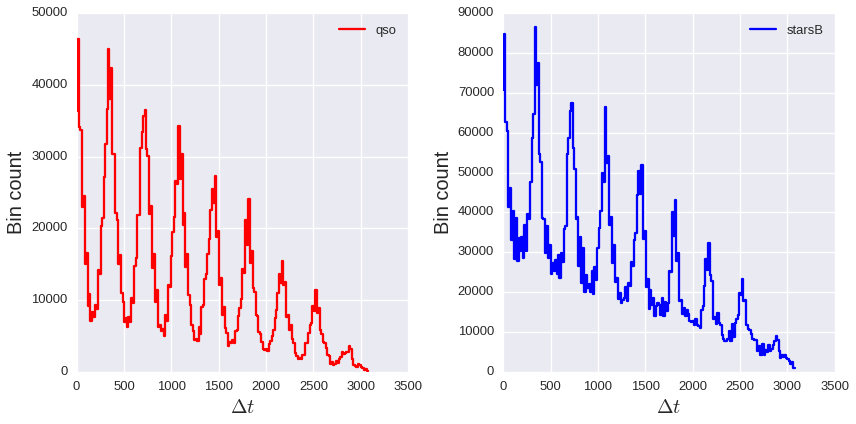

In [15]:
%matplotlib inline 
import seaborn as sns
sns.set_context('talk')
fig,ax = plt.subplots(1,2, figsize=(12,6))
colors = {'qso':'red', 'starsB':'blue'}
#colors['qso'] = 'red'
for i in range(len(binned_dict.keys())):
    obj = binned_dict.keys()[i]
    hist = binned_dict[obj][0]
    bin_edges = binned_dict[obj][1]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    ax[i].plot(bin_centres, hist, ls='steps', label = obj, color=colors[obj])
    ax[i].legend()
    ax[i].set_xlabel(r'$\Delta t$', fontsize=20)
    ax[i].set_ylabel('Bin count', fontsize=20)
plt.tight_layout()
plt.savefig(outDir+'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+'bin-count_obs.png')

### obsolete code : using full linear fit correction...

In [ ]:
# If we were using the full linear fit to the correction factor as a function of timescale...
# We are not, because the timescale-dependence is much smaller than the magnitude-dependence 
# Read in the linear correction coefficients....
File = '/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_3_data/2016-06-07/fc_starsB_a_b_coeff.txt'
colnames = open(File,'r').read().splitlines()[0][1:].split()
datatable = np.genfromtxt(File, dtype=float)
coeffs = {}
for label, column in zip(colnames, datatable.T):
    coeffs[label] = column
    
# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_4_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_4_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)

print('Today we will save our Fig_4 files in %s'%outDir)